# A2：  germantrafficsigns

## Combine shallow learning with deep learning

In [1]:
#load the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy.io import loadmat
import pickle
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")

from keras import layers
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,ZeroPadding2D,AveragePooling2D,TimeDistributed,Add,Activation,Flatten,Dropout
from keras.preprocessing import image
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions,preprocess_input
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers
from keras.models import Sequential,Model
from keras.layers.recurrent import SimpleRNN
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [2]:
path = '../ten-datasets/germantrafficsigns/'
#load the dataset into a dataframe
df = pd.read_csv(path + 'signnames.csv')

In [3]:
num_classes = df.shape[0]
print(df.shape)
df.head()

(43, 2)


,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [4]:
#load the dataset into a dataframe

training_file = path+"train.p"
testing_file = path+"test.p"
validation_file= path+"valid.p"

with open(training_file, mode='rb') as f:
    train_data = pickle.load(f)
    
with open(testing_file, mode='rb') as f:
    test_data = pickle.load(f)
    
with open(validation_file, mode='rb') as f:
    valid_data = pickle.load(f)

In [5]:
X_train, y_train = train_data['features'],train_data['labels']
X_test, y_test = test_data['features'],test_data['labels']
X_valid, y_valid = valid_data['features'],valid_data['labels']

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(34799, 32, 32, 3)
(34799,)
(4410, 32, 32, 3)
(4410,)


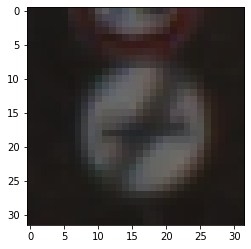

In [7]:
plt.imshow(X_train[0])

In [8]:
y_train.shape

(34799,)

In [9]:

batch_size = 128
num_classes = 43 # 
# epochs = 12

# input image dimensions
img_rows, img_cols = 32, 32 

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 3)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)


X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_valid /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'valid samples')
print(X_test.shape[0], 'test samples')

y_train = y_train.reshape(y_train.shape[0])
y_valid = y_valid.reshape(y_valid.shape[0])
y_test = y_test.reshape(y_test.shape[0])
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

# convert class vectors to binary class matrices  
# y_train = keras.utils.to_categorical(y_train, num_classes) #one hot encoding
# y_valid = keras.utils.to_categorical(y_valid, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)
y_train.shape

X_train shape: (34799, 32, 32, 3)
34799 train samples
4410 valid samples
12630 test samples
(34799,)
(4410,)
(12630,)


(34799,)

## Model 1: Deep feature with shallow learning

>###  Use a middle layer as deep fature from CNN
>###  use shallow learning to classify the deep feature

In [10]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same',input_shape=input_shape))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes+1, activation='softmax'))


# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

hist = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=2,
#                      epochs=5,
                    verbose=1,
                 validation_data=(X_valid, y_valid)
                )

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
________________________________________________

In [11]:
intermediate_layer_model = Model(inputs = model.input, outputs = model.layers[9].output)
# intermediate_layer_model.summary()

In [12]:
X_mid_layer_train = intermediate_layer_model.predict(X_train)
X_mid_layer_test = intermediate_layer_model.predict(X_test)
print(X_mid_layer_train.shape)
print(X_mid_layer_test.shape)

(34799, 512)
(12630, 512)


### Random Forest to train deep features

In [13]:
forest = RandomForestClassifier(criterion='gini', n_estimators = 100, random_state =123)
forest.fit(X_mid_layer_train,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [14]:
y_train_predict = forest.predict(X_mid_layer_train)
print ("forest Train Accuracy: %.3f" % accuracy_score(y_train,y_train_predict))
y_test_predict = forest.predict(X_mid_layer_test)
print ("forest test Accuracy: %.3f" % accuracy_score(y_test,y_test_predict))


forest Train Accuracy: 1.000
forest test Accuracy: 0.935


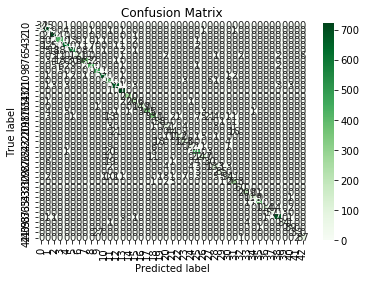

In [15]:
matrix = confusion_matrix(y_test, y_test_predict)
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
labels = np.unique(y_test)
plt.xticks(np.arange(len(labels))+0.5,labels)
plt.ylabel('True label')
plt.yticks(np.arange(len(labels))+0.5,labels)
plt.show()


### Softmax Regression to train deep features

In [16]:
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X_mid_layer_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
y_train_predict = softmax_reg.predict_proba(X_mid_layer_train).argmax(axis = 1)
print ("softmax_reg Train Accuracy: %.3f" % accuracy_score(y_train,y_train_predict))

y_test_predict = softmax_reg.predict_proba(X_mid_layer_test).argmax(axis = 1)
print("softmax_reg Test Accuracy: %.3f" % accuracy_score(y_test,y_test_predict))

softmax_reg Train Accuracy: 1.000
softmax_reg Test Accuracy: 0.935


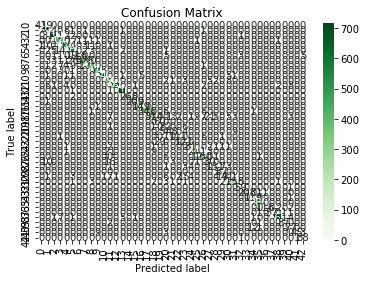

In [18]:
matrix = confusion_matrix(y_test, y_test_predict)
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
labels = np.unique(y_test)
plt.xticks(np.arange(len(labels))+0.5,labels)
plt.ylabel('True label')
plt.yticks(np.arange(len(labels))+0.5,labels)
plt.show()

# Model 2 : Shallow feature with deep learning

>###  Use Random Forest to create new feature
>###  Merge shallow learning feature with dataset
>###  Use MLP to train new dataset

In [19]:
#### Random Forest

In [20]:
def extend_dim(X,y_predict):
    X_list = X.tolist()
    for i in range(len(X_list)):
        X_list[i].append(y_train_predict[i][0])
    return np.array(X_list)

In [21]:
X_train, y_train = train_data['features'],train_data['labels']
X_test, y_test = test_data['features'],test_data['labels']
X_valid, y_valid = valid_data['features'],valid_data['labels']

X_flatten_train = X_train.reshape(len(X_train), -1)
X_flatten_test = X_test.reshape(len(X_test), -1)
X_flatten_valid = X_valid.reshape(len(X_valid), -1)
print(X_flatten_train.shape)
print(X_flatten_test.shape)

X_flatten_train = X_flatten_train / 255.0
X_flatten_test = X_flatten_test / 255.0

(34799, 3072)
(12630, 3072)


In [34]:
forest = RandomForestClassifier(criterion='gini', max_leaf_nodes=50,
                                n_estimators = 800, random_state =1,
                                n_jobs =-1,verbose=True, oob_score=True)
forest.fit(X_flatten_train, y_train)
y_train_predict = forest.predict_proba(X_flatten_train)
y_valid_predict = forest.predict_proba(X_flatten_valid)
y_test_predit = forest.predict_proba(X_flatten_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    6.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Par

In [36]:
X_new_flattern_train = extend_dim(X_flatten_train, y_train_predict)
X_new_flattern_valid = extend_dim(X_flatten_valid , y_valid_predict)
X_new_flattern_test = extend_dim(X_flatten_test, y_test_predit)

print(X_new_flattern_train.shape)
print(X_new_flattern_valid.shape)
print(X_new_flattern_test.shape)

(34799, 3073)
(4410, 3073)
(12630, 3073)


In [37]:
X_new_flattern_train.shape[1:]

(3073,)

In [38]:
X_new_flattern_train.shape[1]

3073

In [40]:
ann_model = Sequential()

ann_model.add(Dense(
        units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_new_flattern_train.shape[1]))

ann_model.add(Dense(units = 512, kernel_initializer = 'uniform', activation = 'relu'))
ann_model.add(Dropout(0.25))
ann_model.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
ann_model.add(Dropout(0.25))

ann_model.add(Dense(units = num_classes,  activation = 'softmax'))

# ann_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann_model.summary()



history = model.fit(X_new_flattern_train, y_train, batch_size=128, epochs=10, validation_data=(X_new_flattern_valid, y_valid))
score = model.evaluate(X_new_flattern_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 128)               393472    
_________________________________________________________________
dense_24 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 43)                11051     
Total params: 601,899
Trainable params: 601,899
Non-trainable params: 0
________________________________________________